In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-28_19-45_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES     7621.1
GC      565.0
NQ     7817.2
YM    11559.4
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

27562.700000000004

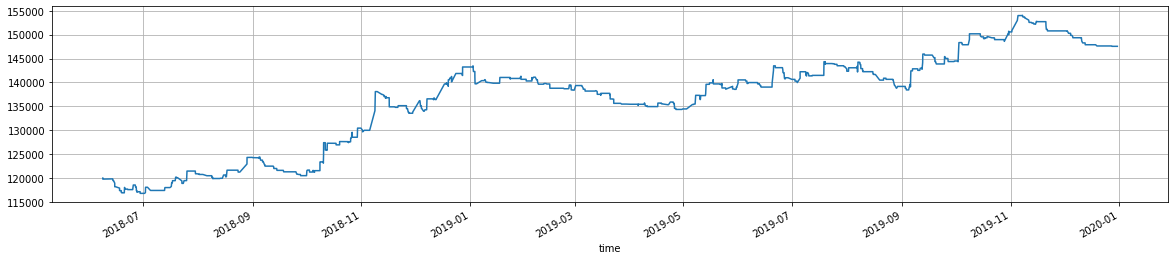

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    234
 GC    250
 NQ    169
 YM    136
 Name: action, dtype: int64,
 789)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.574939
 GC    0.614251
 NQ    0.415233
 YM    0.334152
 Name: action, dtype: float64,
 1.9385749385749387)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    491.4
GC    605.0
NQ    354.9
YM    285.6
Name: commission, dtype: float64

In [15]:
df.commission.sum()

1736.9

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.38,93.06,576.27,-204.30,2.82,92.32,84.0
ES,0.38,65.14,1082.73,-548.21,1.98,71.55,117.0
GC,0.34,4.52,446.09,-227.04,1.96,1.82,125.0
YM,0.40,169.99,892.10,-305.54,2.92,173.52,68.0
total,0.37,69.96,748.97,-329.78,2.27,69.36,394.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.002448,0.042089,0.512320,0.863249
GC,0.002448,1.000000,-0.032760,0.009750,0.266850
NQ,0.042089,-0.032760,1.000000,0.009072,0.308933
YM,0.512320,0.009750,0.009072,1.000000,0.719402
total,0.863249,0.266850,0.308933,0.719402,1.000000


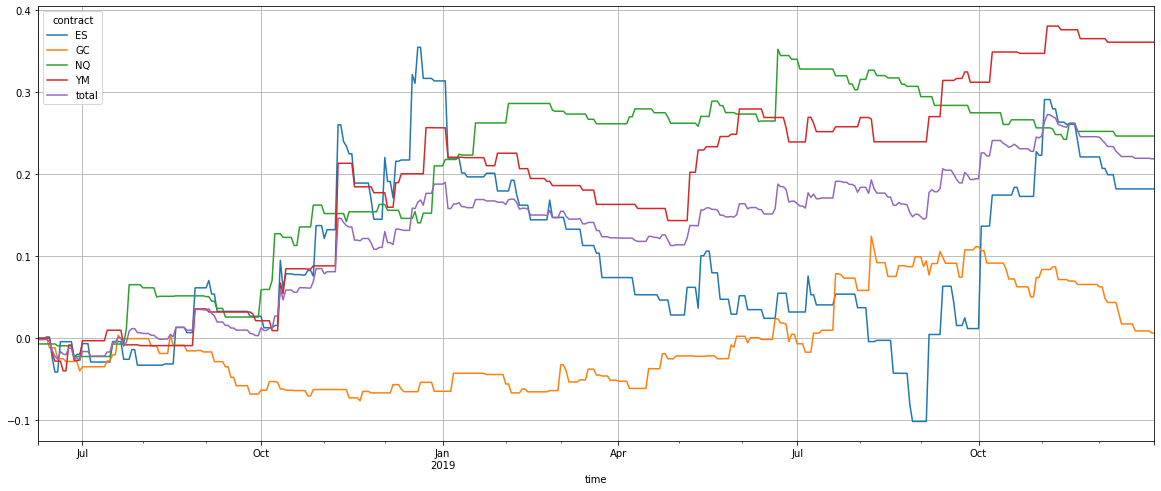

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

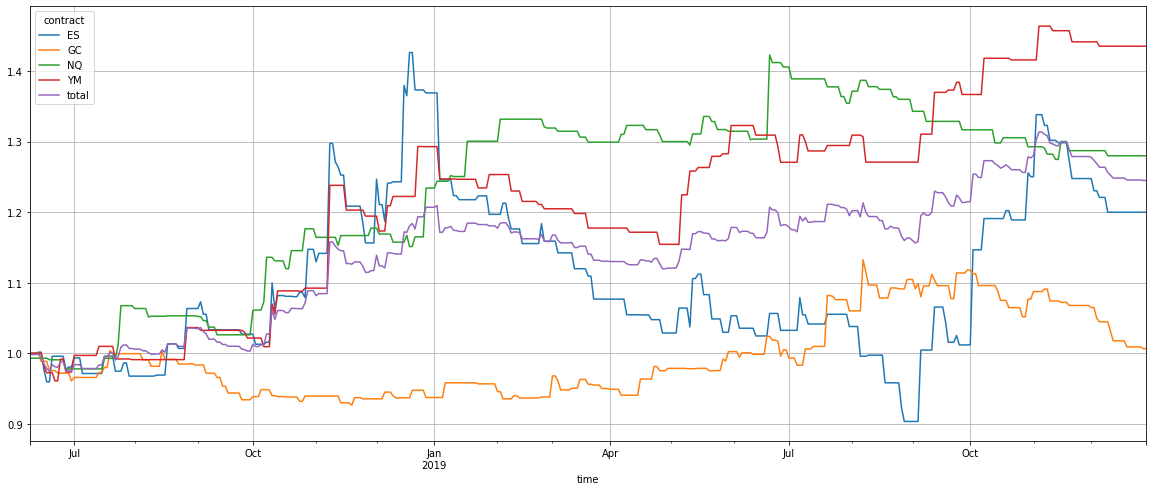

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.119401,0.003978,0.165052,0.250652,0.145190
Cumulative returns,0.199818,0.006433,0.279832,0.435103,0.244778
Annual volatility,0.304322,0.125428,0.132929,0.175917,0.115976
Sharpe ratio,0.516855,0.092969,1.213714,1.356163,1.226245
Calmar ratio,0.325744,0.035731,1.585772,2.336376,1.961169
Stability,0.071638,0.492264,0.688386,0.864761,0.826921
Max drawdown,-0.366548,-0.111339,-0.104083,-0.107282,-0.074032
Omega ratio,1.194838,1.031307,1.735847,1.922744,1.392596
Sortino ratio,1.059756,0.181127,3.684598,3.621220,2.664633
Skew,3.164807,3.967233,6.054776,5.837522,3.090288


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-1.95,-3.92,-2.21,-2.66,-2.65
2018-07-31,-1.31,4.03,9.16,1.81,3.41
2018-08-31,9.90,-1.61,-1.35,4.59,2.83
2018-09-30,-3.41,-5.01,-2.55,-1.44,-3.10
2018-10-31,11.71,0.56,14.64,6.93,8.52
2018-11-30,0.78,-0.41,0.08,9.34,2.61
2018-12-31,18.38,0.20,4.81,8.24,8.03
2019-01-31,-12.57,2.06,5.38,-3.06,-2.18
2019-02-28,-3.17,-1.94,1.44,-3.87,-1.88


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       20.0
GC        1.0
NQ       28.0
YM       44.0
total    24.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 15:07:00,ES,SELL,2805.00,4095.8
2018-11-08 20:40:30,YM,SELL,26089.00,4000.8
2019-10-02 21:00:00,ES,BUY,2893.75,3995.8
2019-09-05 20:28:30,ES,SELL,2975.25,3358.3
2018-12-17 17:03:00,ES,BUY,2597.00,3295.8
...,...,...,...,...
2019-08-27 14:26:00,ES,BUY,2892.75,-1116.7
2019-01-03 00:00:00,ES,SELL,2485.50,-1179.2
2019-08-19 08:17:00,ES,BUY,2912.00,-1179.2


In [25]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2018-11-08,0.136527,0.000000,0.000000,0.133360,0.067472
2018-10-10,0.082777,-0.008161,0.000000,0.059860,0.033619
2019-10-02,0.133193,-0.004828,0.000000,0.000000,0.032091
2019-09-05,0.111943,-0.017161,0.000000,0.031193,0.031494
2019-06-20,0.031110,0.000000,0.091527,0.000000,0.030659
...,...,...,...,...,...
2018-10-11,-0.033890,0.000000,-0.004473,-0.013140,-0.012876
2018-12-04,-0.028890,0.000000,-0.007140,-0.017640,-0.013418
2019-06-26,-0.022640,-0.020828,0.000000,-0.017307,-0.015194
